**The core notebooks for this project are:**

*   01_eda_data_cleaning.ipynb
*   02_baseline_models.ipynb
*   03_transformers.ipynb
*  streamlit_prototype.ipynb



**Notebook 02 - Baseline Models**

This notebook implements and evaluates baseline machine learning models using TF-IDF features. It establishes reference performance at both emotion and quadrant levels for comparison with transformer-based approaches.

In [1]:
#project paths:
#project root: /content/drive/MyDrive/applied_research_project/
#cleaned data directory: /content/drive/MyDrive/applied_research_project/data
#prototype directory: /content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype
#best model storage path: /content/drive/MyDrive/applied_research_project/burnout_indicator_detection_prototype/best_emo_model

# 1.Import Libraries

In [2]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#main python and data handling libraries
import numpy as np
import pandas as pd
import os

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning & evaluation metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, f1_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import joblib
import sys

#add project root to Python path to import utils.py
sys.path.append('/content/drive/MyDrive/applied_research_project')
import utils

# 2.Loading Data

This section loads the preprocessed text inputs for baseline models and targets from Notebook 01 and retrieves the official GoEmotions emotion list.

In [4]:
#directory containing preprocessed features and labels
data_dir = "/content/drive/MyDrive/applied_research_project/data"

#load TF-IDF features for baseline models
X_train_tfidf = joblib.load(f"{data_dir}/X_train_tfidf.pkl")
X_val_tfidf   = joblib.load(f"{data_dir}/X_val_tfidf.pkl")
X_test_tfidf  = joblib.load(f"{data_dir}/X_test_tfidf.pkl")

#load emotion targets
y_train = joblib.load(f"{data_dir}/y_train.pkl")
y_val   = joblib.load(f"{data_dir}/y_val.pkl")
y_test  = joblib.load(f"{data_dir}/y_test.pkl")

In [5]:
#load the GoEmotions emotion list from the official Google Research Repository
emotions_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/emotions.txt'
emotions=pd.read_csv(emotions_url,header=None)

#initialise label binarizer and fix emotion class order for consistency across models
mlb = MultiLabelBinarizer()
mlb.classes_ = emotions.iloc[:, 0].values

# 3.Baseline Models

For the baseline models, Logistic Regression and a LinearSVC were used.


Two approaches were explored:

- Direct Category-Level Training (Exploratory),

- Per-Emotion Prediction with Quadrant Aggregation (Primary).

In the exploratory approach, models were trained directly on five affective quadrants.


In the primary approach, models were trained at the individual emotion level performing multi-label classification, with emotion-level predictions later aggregated into quadrants.


In [6]:
#function to convert target arrays to category-level labels
def y_to_categories(y, categories, cat_to_emoIds):
  y=y.toarray() if hasattr(y, "toarray") else np.asarray(y)
  y_cat=np.zeros((y.shape[0], len(categories)), dtype=int)

  #mark a category as present if any of its emotions are present
  for j, c in enumerate(categories):
    y_cat[:, j]=(y[:, cat_to_emoIds[c]].sum(axis=1)>0).astype(int)

  return y_cat

## 3.1.Logistic Regression - Direct Category Training

In [7]:
#Logistic Regression - Direct Category Training

#map emotions to categories and create category and emotion id mappings
emo_to_cat=[utils.categorize_emotion(emotions.iloc[i, 0]) for i in range(len(emotions))]
categories=sorted(set(emo_to_cat))
cat_to_emoIds={cat: [i for i, c in enumerate(emo_to_cat) if c==cat] for cat in categories}

#convert train, val, and test emotion labels to category-level labels
y_train_cat=y_to_categories(y_train, categories, cat_to_emoIds)
y_val_cat=y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=y_to_categories(y_test, categories, cat_to_emoIds)

#initialize One-vs-Rest Logistic Regression with liblinear solver
baseline_lr_liblinear=OneVsRestClassifier(
    LogisticRegression(
         max_iter=1000,
         class_weight='balanced',
         solver='liblinear'
    )
)

#fit the model on train split with category-level labels
baseline_lr_liblinear.fit(X_train_tfidf, y_train_cat)

#get predicted probabilities from val and test splits
val_scores_lr_cat= baseline_lr_liblinear.predict_proba(X_val_tfidf)
test_scores_lr_cat= baseline_lr_liblinear.predict_proba(X_test_tfidf)

#compute optimal per-label thresholds using validation data
ts_label = utils.best_thresholds_per_label(val_scores_lr_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)

#fixed 0.5 baseline threshold
ts_baseline = utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val split
val_metrics_lr=utils.evaluate_run(y_val_cat, val_scores_lr_cat, ts_label, label_names=categories, title="LR Model (Val Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)
utils.evaluate_run(y_val_cat, val_scores_lr_cat, ts_baseline, label_names=categories, title="LR Model (Val Split): Direct Category Training\nFixed 0.5 Thresholds\n")

#evaluate model performance on test split
test_metrics_lr=utils.evaluate_run(y_test_cat, test_scores_lr_cat, ts_label, label_names=categories, title="LR Model (Test Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)
utils.evaluate_run(y_test_cat, test_scores_lr_cat, ts_baseline, label_names=categories, title="LR Model (Test Split): Direct Category Training\nFixed 0.5 Thresholds\n")


LR Model (Val Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.69
Macro F1: 0.66

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.64      0.86      0.73      2341
    pleasant_active       0.73      0.72      0.73      1623
  pleasant_deactive       0.83      0.63      0.72       702
  unpleasant_active       0.49      0.59      0.53       891
unpleasant_deactive       0.54      0.58      0.56       389

          micro avg       0.65      0.74      0.69      5946
          macro avg       0.65      0.68      0.66      5946
       weighted avg       0.66      0.74      0.69      5946
        samples avg       0.68      0.76      0.70      5946


LR Model (Val Split): Direct Category Training
Fixed 0.5 Thresholds

Micro F1: 0.67
Macro F1: 0.64

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.67      0.78      0.73      234

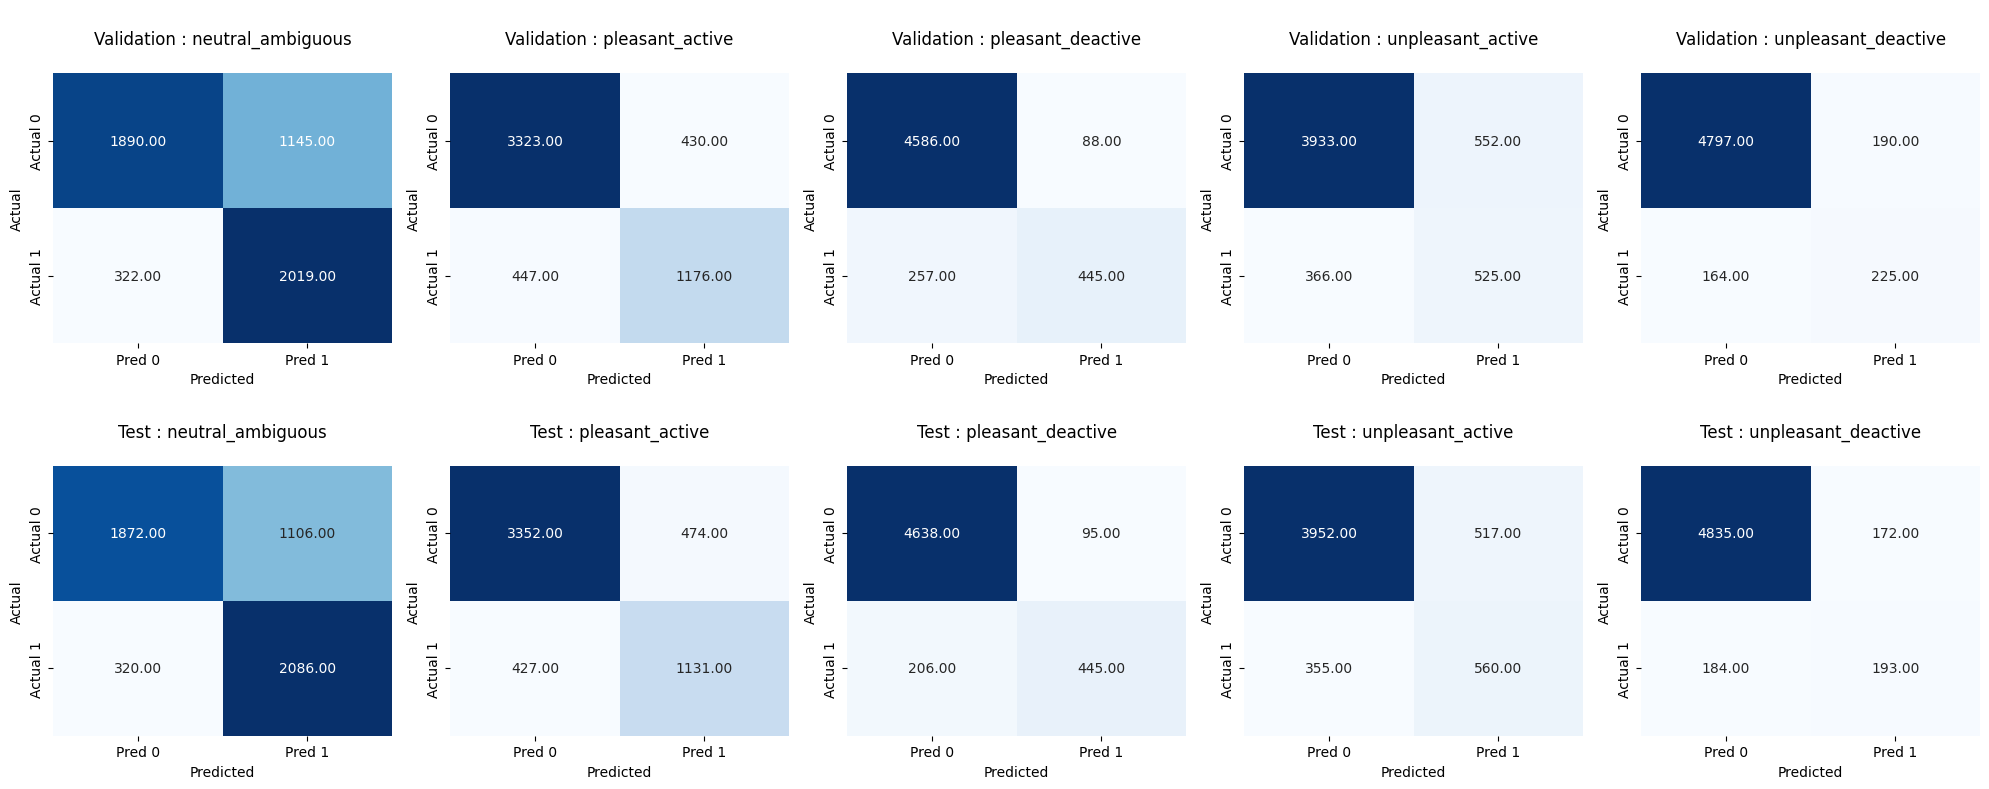

In [8]:
#compute per-category confusion matrices for val and test splits
cm_val_lr_direct_cat=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_lr_cat, ts_label, categories)

cm_test_lr_direct_cat=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_lr_cat,ts_label, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_lr_direct_cat, cm_test_lr_direct_cat, categories, normalize=False)

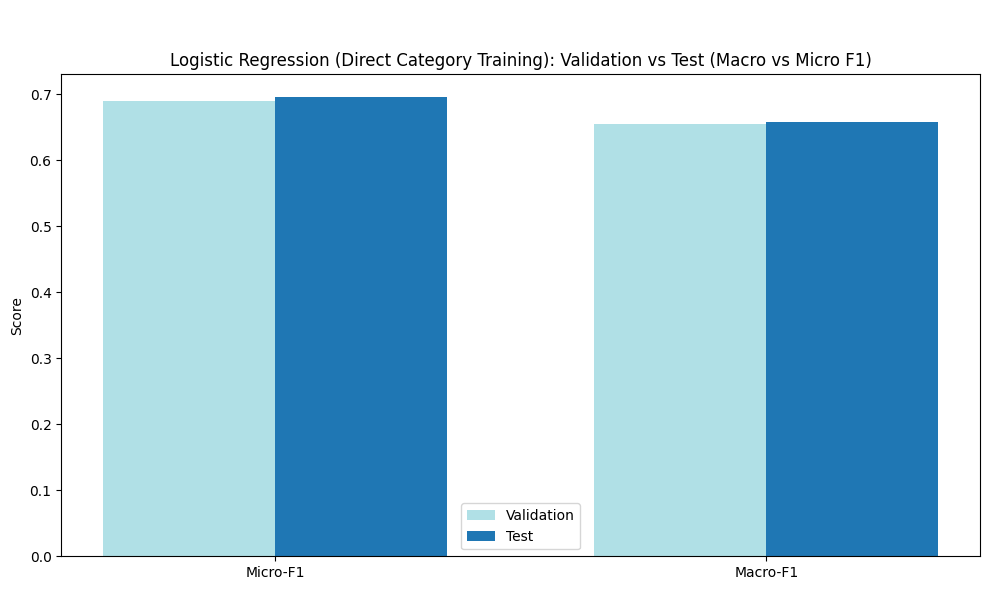

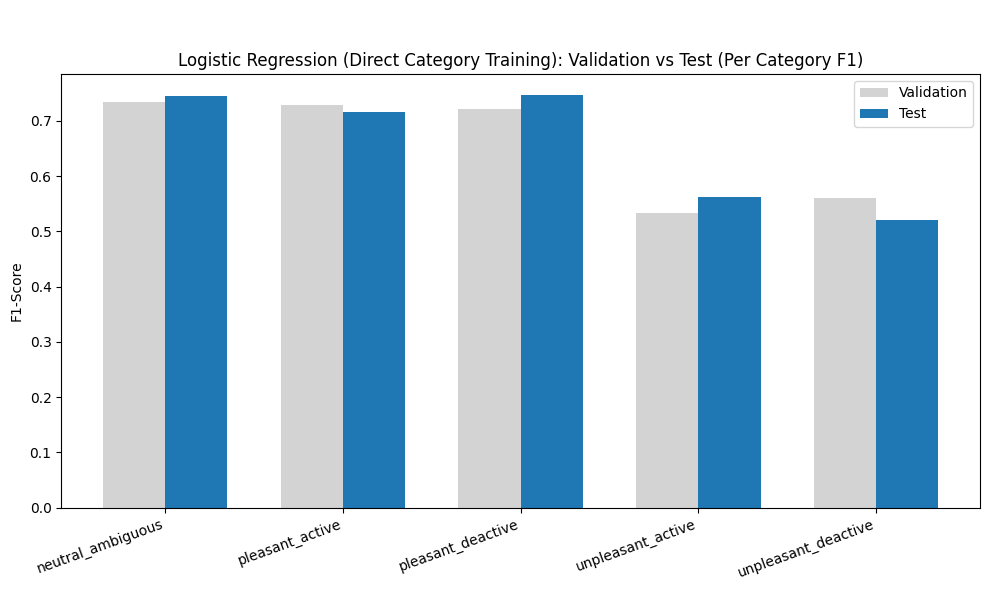

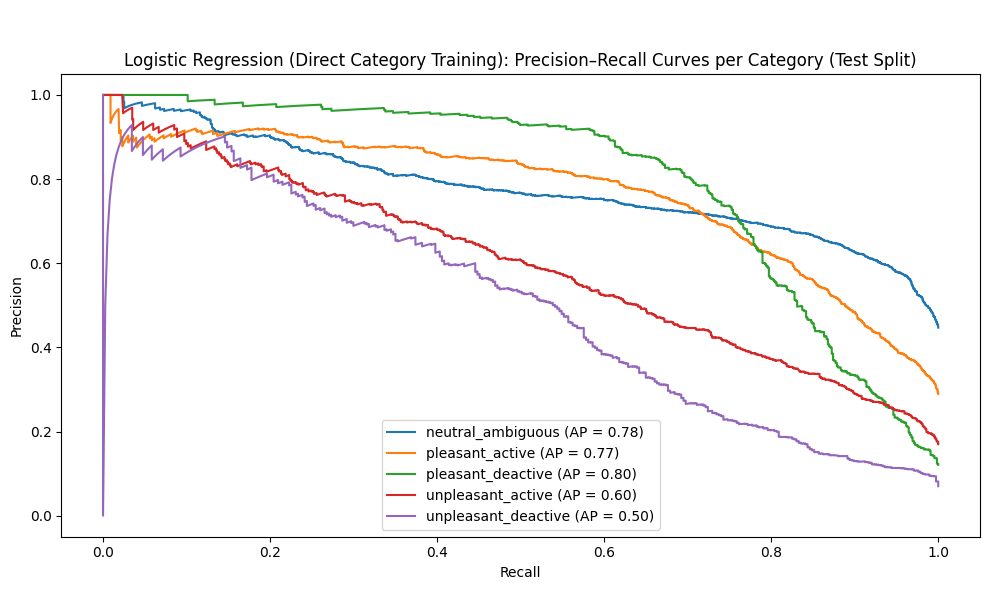

In [9]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_lr, test_metrics_lr, model_name="Logistic Regression (Direct Category Training)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_lr, test_metrics_lr, categories, model_name="Logistic Regression (Direct Category Training)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_lr_cat, categories, model_name="Logistic Regression (Direct Category Training)")

## 3.2.LinearSVC -  Direct Category Training

In [10]:
#LinearSVC - Direct Category Training

#initialise the LinearSVC baseline model (One-vs-Rest)
baseline_svc=OneVsRestClassifier(
    LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=5000,
        verbose=0
    )
)

#fit the model on train split with category-level labels
baseline_svc.fit(X_train_tfidf, y_train_cat)

#get raw decision scores from val and test splits
val_scores_svc_cat= np.array(baseline_svc.decision_function(X_val_tfidf))
test_scores_svc_cat= np.array(baseline_svc.decision_function(X_test_tfidf))

#compute optimal per-label thresholds using validation data
ts_label = utils.best_thresholds_per_label(val_scores_svc_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=True)

#fixed 0.5 baseline threshold
ts_baseline = utils.baseline_thresholds(y_val_cat)

#convert SVC decision scores to probabilities using sigmoid
val_probs_svc_cat= 1 / (1 + np.exp(-val_scores_svc_cat))
test_probs_svc_cat= 1 / (1 + np.exp(-test_scores_svc_cat))

#evaluate on val split
val_metrics_svc_cat=utils.evaluate_run(y_val_cat, val_probs_svc_cat, ts_label, label_names=categories, title="LinearSVC (Val Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)
utils.evaluate_run(y_val_cat, val_probs_svc_cat, ts_baseline, label_names=categories, title="LinearSVC (Val Split): Direct Category Training\nFixed 0.5 Thresholds\n")

#evaluate on test split
test_metrics_svc_cat=utils.evaluate_run(y_test_cat, test_probs_svc_cat, ts_label, label_names=categories, title="LinearSVC (Test Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)
utils.evaluate_run(y_test_cat, test_probs_svc_cat, ts_baseline, label_names=categories, title="LinearSVC (Test Split): Direct Category Training\nFixed 0.5 Thresholds\n")


LinearSVC (Val Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.66
Macro F1: 0.62

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.59      0.89      0.71      2341
    pleasant_active       0.66      0.74      0.70      1623
  pleasant_deactive       0.72      0.66      0.69       702
  unpleasant_active       0.44      0.57      0.50       891
unpleasant_deactive       0.43      0.59      0.50       389

          micro avg       0.58      0.75      0.66      5946
          macro avg       0.57      0.69      0.62      5946
       weighted avg       0.59      0.75      0.66      5946
        samples avg       0.63      0.77      0.67      5946


LinearSVC (Val Split): Direct Category Training
Fixed 0.5 Thresholds

Micro F1: 0.64
Macro F1: 0.61

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.66      0.72      0.69      2

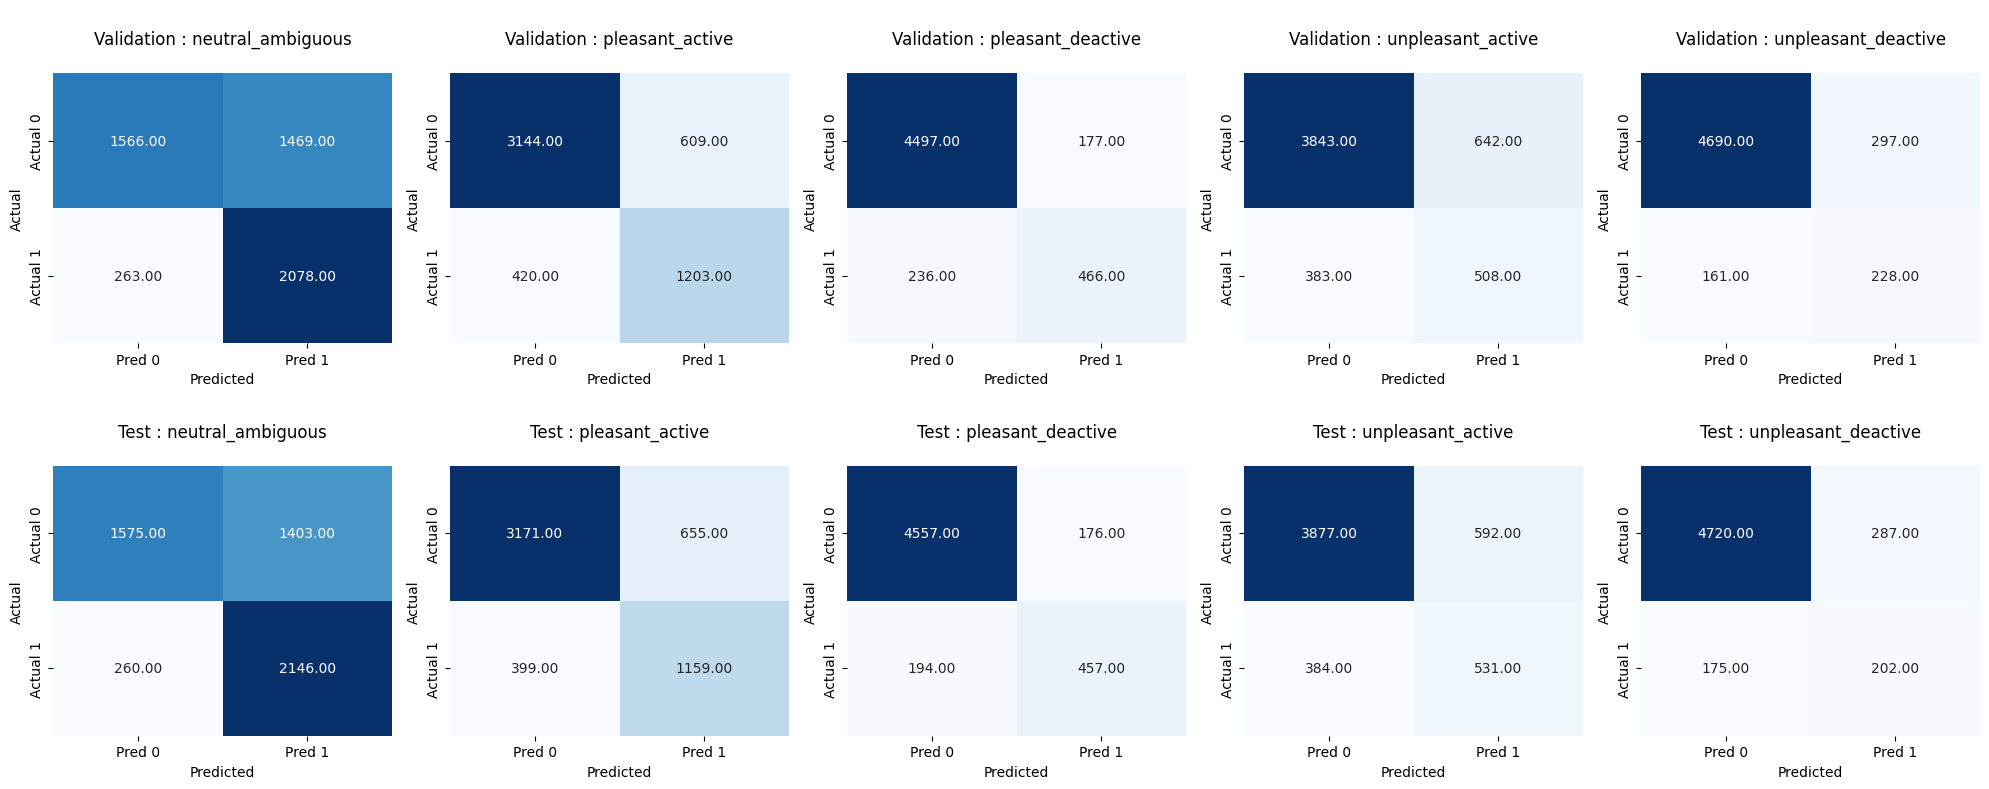

In [11]:
#compute per-category confusion matrices for val and test splits
cm_val_svc_direct_cat=utils.confusion_matrices_per_label(
    y_val_cat, val_probs_svc_cat, ts_label, categories)

cm_test_svc_direct_cat=utils.confusion_matrices_per_label(
    y_test_cat, test_probs_svc_cat,ts_label, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_svc_direct_cat, cm_test_svc_direct_cat, categories, normalize=False)

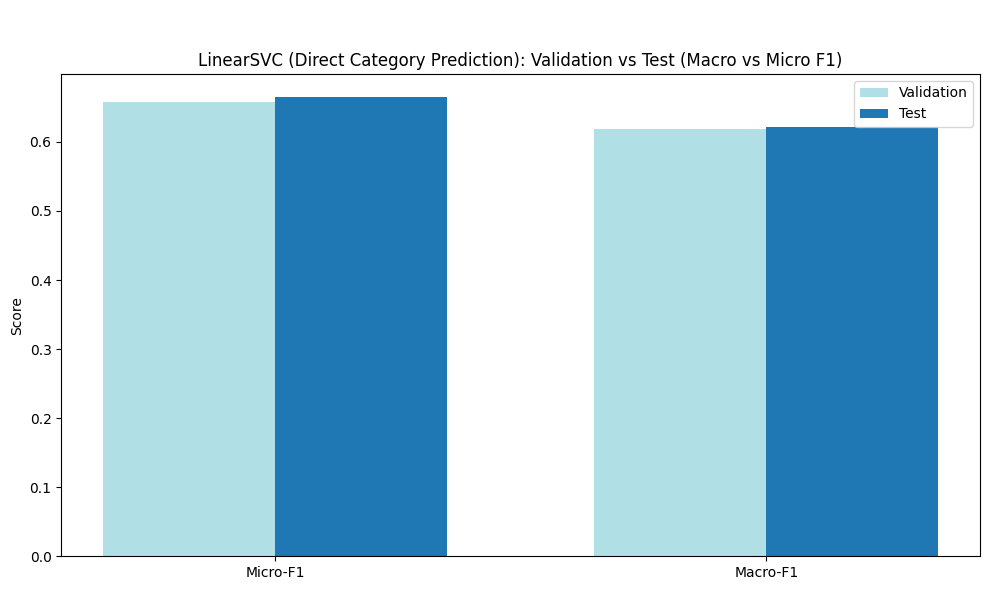

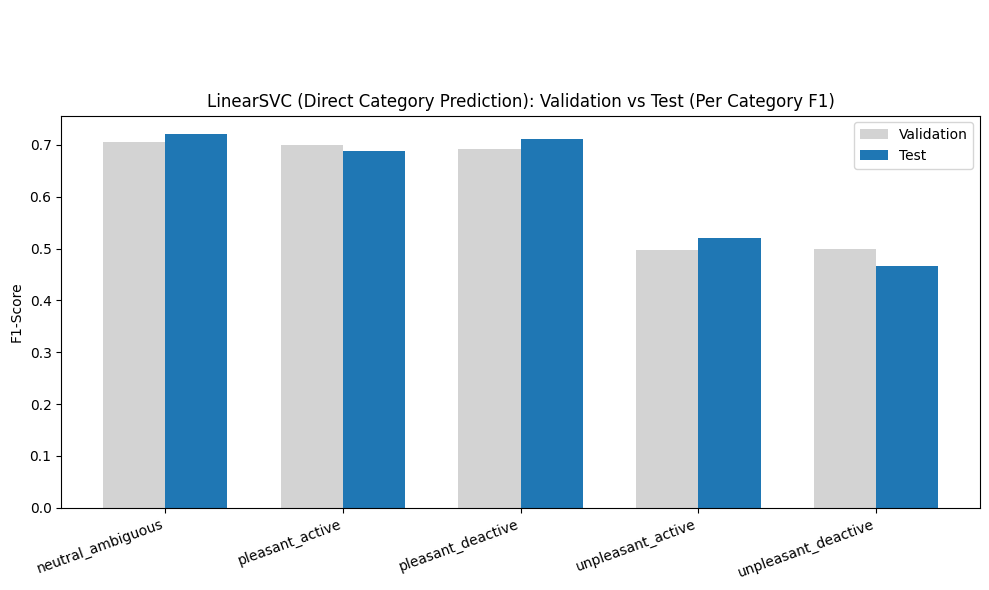

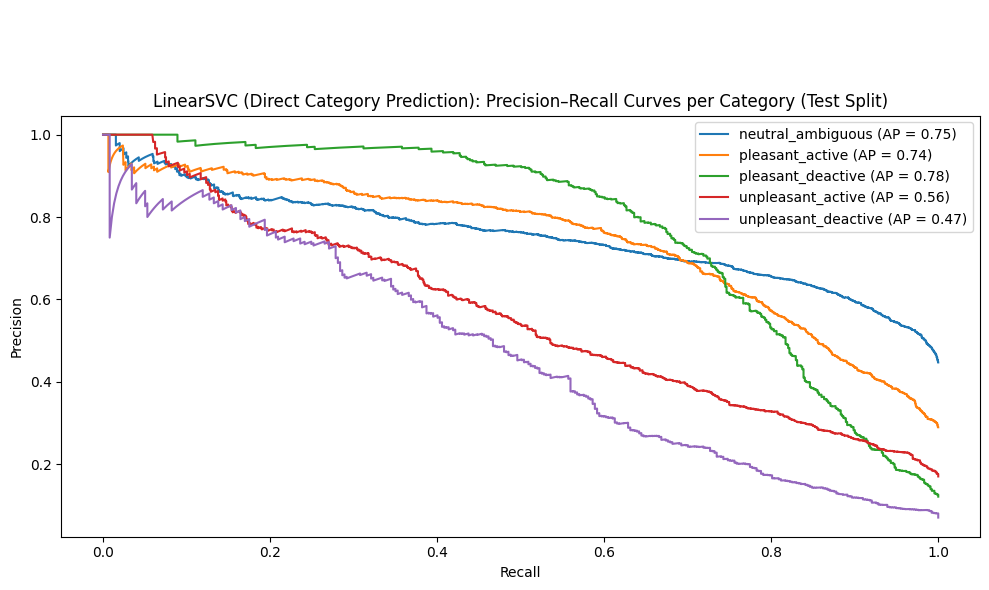

In [12]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_svc_cat, test_metrics_svc_cat, model_name="LinearSVC (Direct Category Prediction)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_svc_cat, test_metrics_svc_cat, categories, model_name="\n\nLinearSVC (Direct Category Prediction)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_svc_cat, categories, model_name="\n\nLinearSVC (Direct Category Prediction)")

## 3.3. Logistic Regression -  Per Emotion Prediction to Quadrant Aggregation

### 3.3.1. Logistic Regression - Per-Emotion Prediction

In [13]:
#Logistic Regression - Per Emotion Prediction

#fit model on train split with emotion-level labels
baseline_lr_liblinear.fit(X_train_tfidf, y_train)

#get predicted probabilities from val and test splits
val_scores_lr = baseline_lr_liblinear.predict_proba(X_val_tfidf)
test_scores_lr = baseline_lr_liblinear.predict_proba(X_test_tfidf)

#compute per-label thresholds and fixed baseline thresholds
ts_label=utils.best_thresholds_per_label(val_scores_lr, y_val, n_grid=50, use_quantiles=False, scores_are_logits=False) #per emotion threshold
ts_baseline=utils.baseline_thresholds(y_val)

#evaluate model performance on val split
utils.evaluate_run(y_val, val_scores_lr, ts_label, label_names=mlb.classes_, title="LR Model (Val Split): Per Emotion Prediction\nPer-Label Thresholds\n")
utils.evaluate_run(y_val, val_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR Model (Val Split): Per Emotion Prediction\nFixed 0.5 Thresholds\n")

#evaluate model performance on test split
utils.evaluate_run(y_test, test_scores_lr, ts_label, label_names=mlb.classes_, title="LR Model (Test Split): Per Emotion Prediction\nPer-Label Thresholds\n")
utils.evaluate_run(y_test, test_scores_lr, ts_baseline, label_names=mlb.classes_, title="LR Model (Test Split): Per Emotion Prediction\nFixed 0.5 Thresholds\n")


LR Model (Val Split): Per Emotion Prediction
Per-Label Thresholds

Micro F1: 0.54
Macro F1: 0.49

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.63      0.72      0.68       485
     amusement       0.66      0.87      0.75       301
         anger       0.39      0.48      0.43       192
     annoyance       0.25      0.40      0.31       303
      approval       0.27      0.36      0.31       394
        caring       0.33      0.38      0.36       152
     confusion       0.25      0.48      0.33       149
     curiosity       0.38      0.77      0.51       247
        desire       0.52      0.52      0.52        77
disappointment       0.18      0.34      0.23       162
   disapproval       0.28      0.32      0.30       292
       disgust       0.42      0.47      0.44        96
 embarrassment       0.47      0.54      0.51        35
    excitement       0.20      0.36      0.25        94
          fear       0.64   

### 3.3.2.Quadrant-Level Evaluation

In [14]:
#convert emotion-level probabilities to category-level probabilities
def probs_emo_to_cat(probs_emo, categories, cat_to_emoIds, mode="noisy_or"):
  n, c=probs_emo.shape[0], len(categories)
  out=np.zeros((n,c), dtype=np.float32)
  for j, cat in enumerate(categories):
    idxs=cat_to_emoIds[cat]

    if len(idxs)==0:
      out[:,j]=0.0
    elif len(idxs)==1:
      out[:,j]=probs_emo[:,idxs[0]]
    elif mode=="noisy_or":
      out[:,j]=1.0-np.prod(1.0-probs_emo[:, idxs], axis=1)
    elif mode=="max":
      out[:,j]=probs_emo[:, idxs].max(axis=1)
    else:
      raise ValueError("Aggregation mode must be either 'noisy or' or 'max'")
  return out

In [15]:
#aggregate emotion-level predictions to category-level using noisy-or aggregation
val_scores_cat=probs_emo_to_cat(val_scores_lr, categories, cat_to_emoIds, mode="noisy_or")
test_scores_cat=probs_emo_to_cat(test_scores_lr, categories, cat_to_emoIds, mode="noisy_or")

#convert target labels from emotion-level to category-level
y_val_cat=y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=y_to_categories(y_test, categories, cat_to_emoIds)

#compute per-label thresholds and fixed baseline thresholds
ts_quadrant=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, scores_are_logits=False)
ts_baseline=utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val and test splits
val_metrics_lr_per_qua=utils.evaluate_run(y_val_cat, val_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Val Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)

utils.evaluate_run(y_val_cat, val_scores_cat, ts_baseline, label_names=categories,
             title="LR Model (Val Split): Quadrant Aggregation\nFixed 0.5 Thresholds\n")

test_metrics_lr_per_qua=utils.evaluate_run(y_test_cat, test_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Test Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)

utils.evaluate_run(y_test_cat, test_scores_cat, ts_baseline, label_names=categories,
             title="LR Model (Test Split): Quadrant Aggregation\nFixed 0.5 Thresholds\n")


LR Model (Val Split): Quadrant Aggregation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.68
Macro F1: 0.65

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.61      0.90      0.72      2341
    pleasant_active       0.67      0.74      0.71      1623
  pleasant_deactive       0.76      0.69      0.72       702
  unpleasant_active       0.49      0.58      0.53       891
unpleasant_deactive       0.53      0.57      0.55       389

          micro avg       0.61      0.76      0.68      5946
          macro avg       0.61      0.70      0.65      5946
       weighted avg       0.62      0.76      0.68      5946
        samples avg       0.66      0.78      0.69      5946


LR Model (Val Split): Quadrant Aggregation
Fixed 0.5 Thresholds

Micro F1: 0.54
Macro F1: 0.51

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.54      0.97 

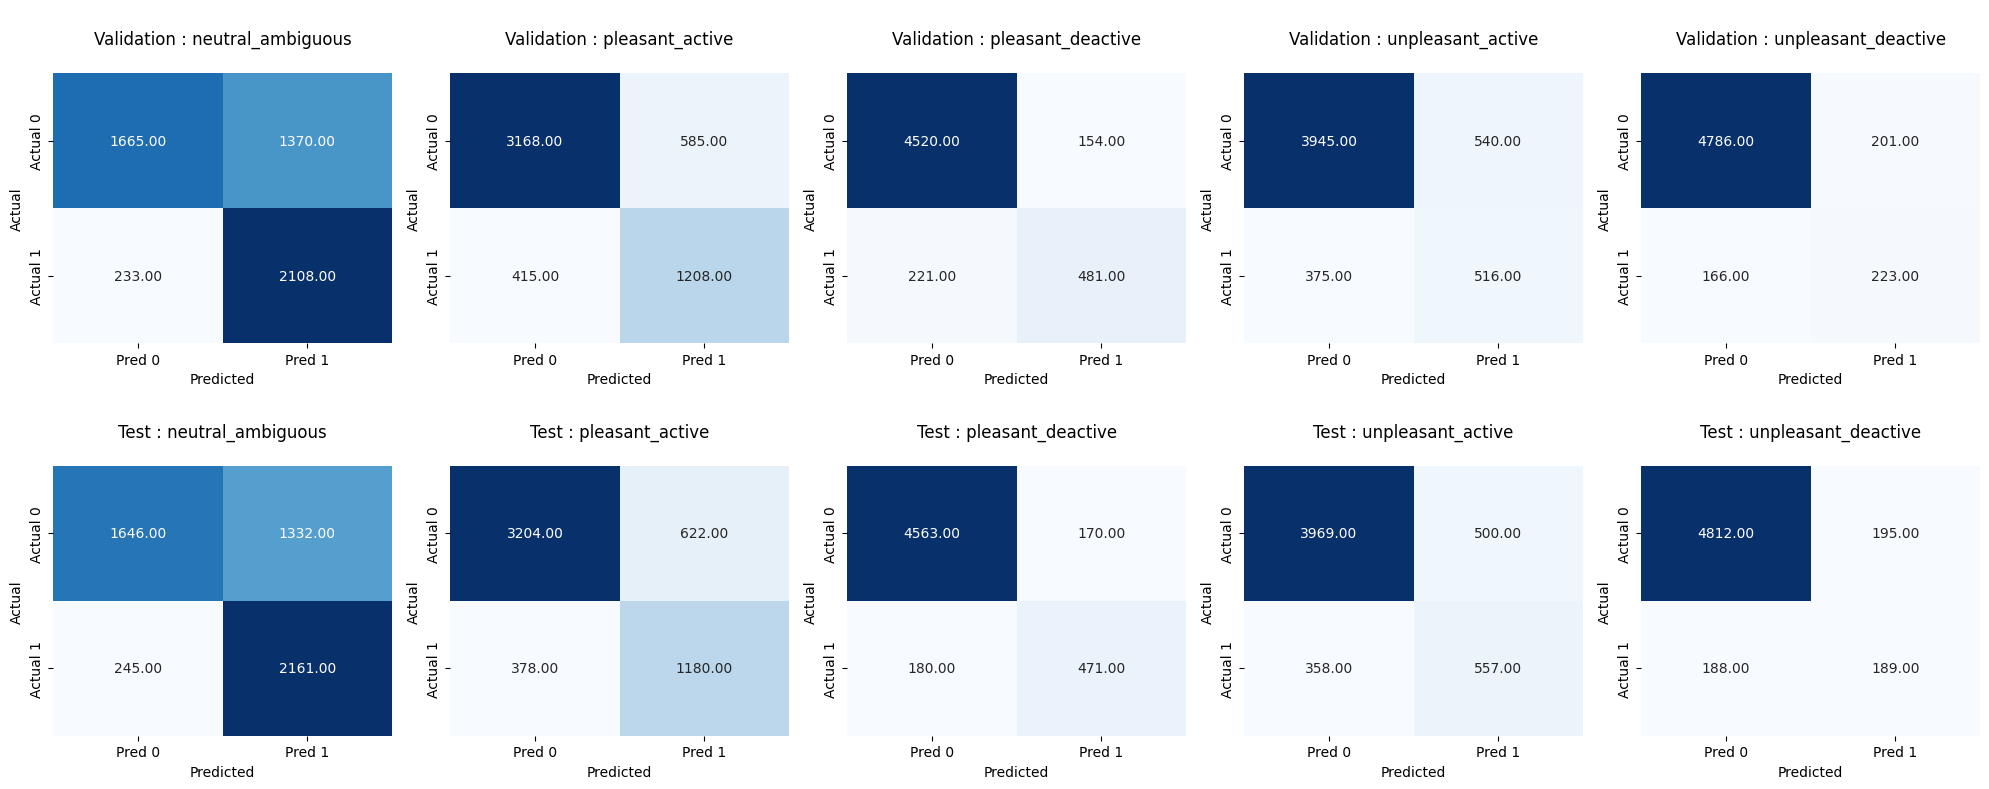

In [16]:
#compute per-category confusion matrices for val and test splits
cm_val_lr_quadrant=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_cat, ts_quadrant, categories)

cm_test_lr_quadrant=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_cat,ts_quadrant, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_lr_quadrant, cm_test_lr_quadrant, categories, normalize=False)

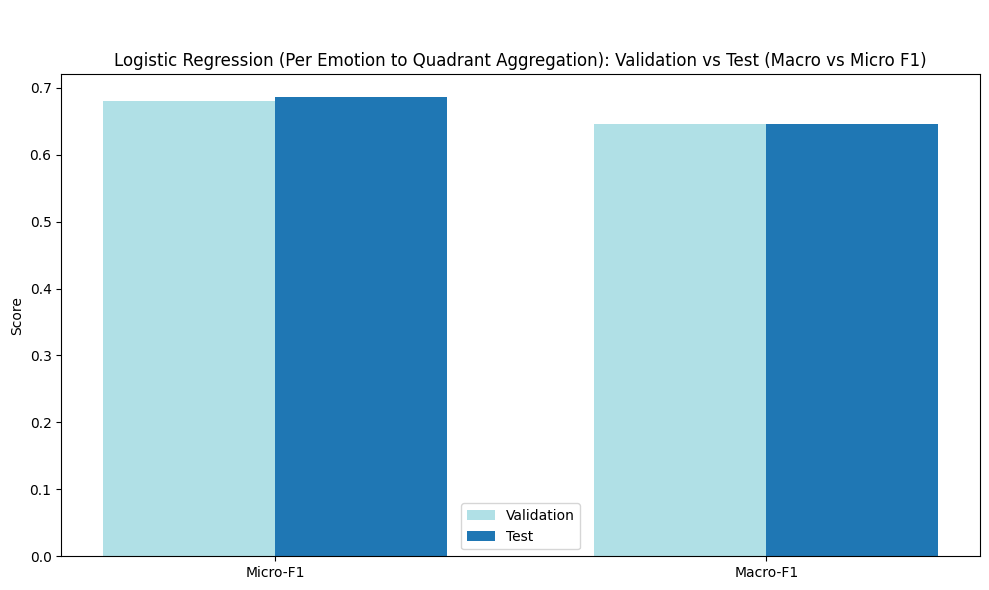

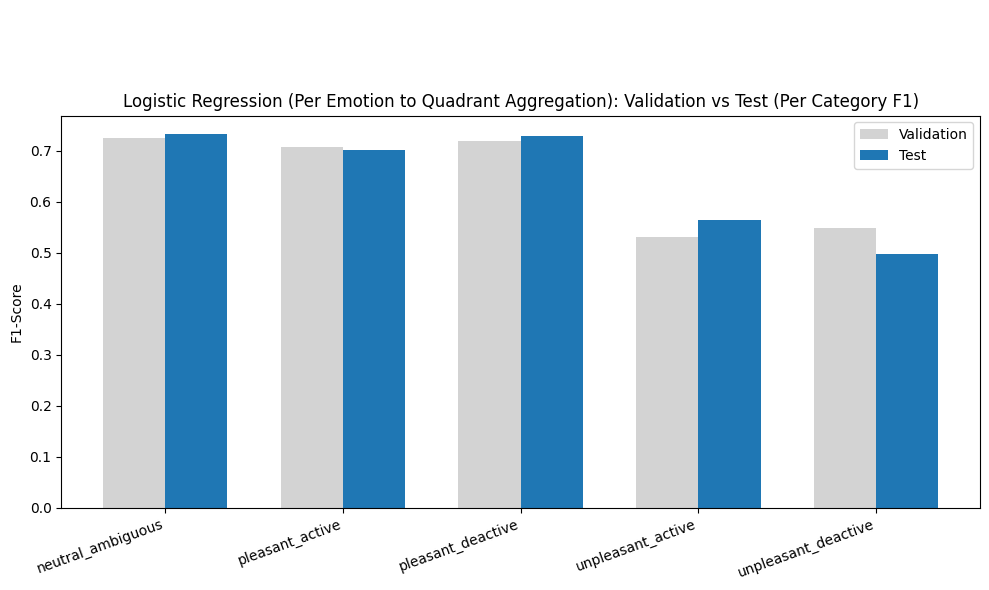

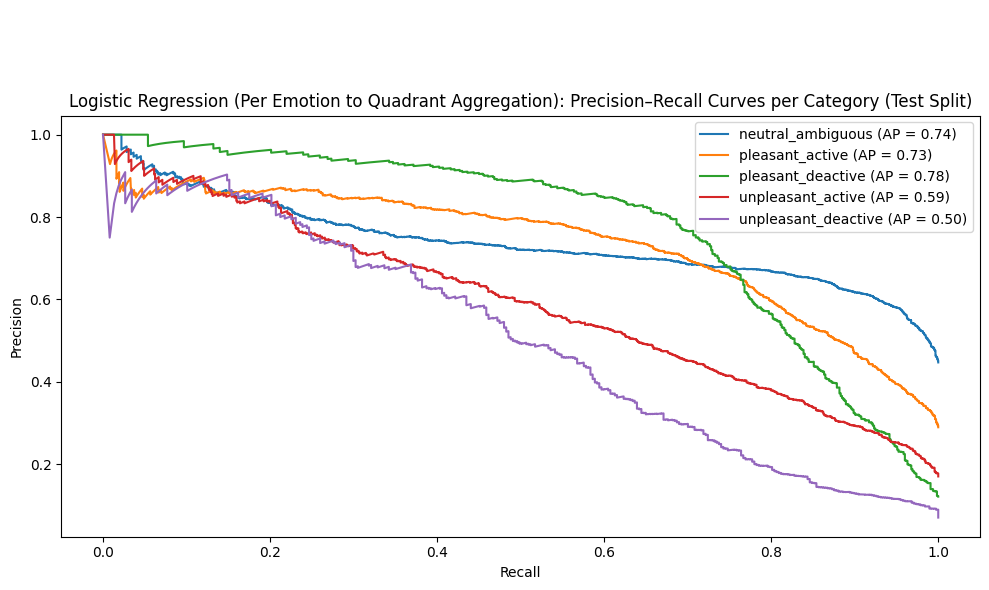

In [17]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_lr_per_qua, test_metrics_lr_per_qua, model_name="Logistic Regression (Per Emotion to Quadrant Aggregation)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_lr_per_qua, test_metrics_lr_per_qua, categories, model_name="\n\nLogistic Regression (Per Emotion to Quadrant Aggregation)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name="\n\nLogistic Regression (Per Emotion to Quadrant Aggregation)")

## 3.4. LinearSVC -  Per-Emotion Prediction to Quadrant Aggregation

### 3.4.1.LinearSVC - Per-Emotion Prediction

In [18]:
#LinearSVC - Per-Emotion Prediction

#fit model on train split with emotion-level labels
baseline_svc.fit(X_train_tfidf, y_train)

#get raw decision scores from val and test splits
val_scores_svc=np.array(baseline_svc.decision_function(X_val_tfidf))
test_scores_svc=np.array(baseline_svc.decision_function(X_test_tfidf))

#compute per-label thresholds and fixed baseline thresholds
ts_label=utils.best_thresholds_per_label(val_scores_svc, y_val, n_grid=50, use_quantiles=False, scores_are_logits=True) #get thresholds per emotion
ts_baseline=utils.baseline_thresholds(y_val)

#apply sigmoid to convert SVC decision scores to probabilities
val_probs_svc= 1 / (1 + np.exp(-val_scores_svc))
test_probs_svc= 1 / (1 + np.exp(-test_scores_svc))

#evaluate on val split
utils.evaluate_run(y_val, val_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC (Val Split): Per-Emotion Prediction\nPer-label Thresholds\n")
utils.evaluate_run(y_val, val_probs_svc, ts_baseline, label_names=mlb.classes_, title="LinearSVC (Val Split): Per-Emotion Prediction\nFixed 0.5 Thresholds\n")

#evaluate on test split
utils.evaluate_run(y_test, test_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC (Test Split): Per-Emotion Prediction\nPer-label Thresholds \n")
utils.evaluate_run(y_test, test_probs_svc, ts_baseline, label_names=mlb.classes_, title="LinearSVC (Test Split): Per-Emotion Prediction\nFixed 0.5 Thresholds\n")


LinearSVC (Val Split): Per-Emotion Prediction
Per-label Thresholds

Micro F1: 0.49
Macro F1: 0.43

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.62      0.61      0.62       485
     amusement       0.72      0.80      0.75       301
         anger       0.40      0.38      0.39       192
     annoyance       0.20      0.37      0.25       303
      approval       0.22      0.36      0.27       394
        caring       0.23      0.39      0.29       152
     confusion       0.23      0.44      0.30       149
     curiosity       0.43      0.47      0.45       247
        desire       0.45      0.52      0.48        77
disappointment       0.13      0.31      0.19       162
   disapproval       0.29      0.23      0.25       292
       disgust       0.30      0.52      0.38        96
 embarrassment       0.36      0.46      0.41        35
    excitement       0.18      0.26      0.21        94
          fear       0.48  

### 3.4.2.LinearSVC - Quadrant-Level Evaluation

In [19]:
#Quadrant-Level Evaluation

#aggregate emotion-level prediction scores to category-level using noisy-or aggregation
val_probs_cat_svc=probs_emo_to_cat(val_probs_svc, categories, cat_to_emoIds, mode="noisy_or")
test_probs_cat_svc=probs_emo_to_cat(test_probs_svc, categories, cat_to_emoIds, mode="noisy_or")

#convert target labels from emotion-level to category-level
y_val_cat  = y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat = y_to_categories(y_test, categories, cat_to_emoIds)

#compute per-label thresholds and fixed baseline thresholds
ts_quadrant=utils.best_thresholds_per_label(val_probs_cat_svc, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)
ts_baseline=utils.baseline_thresholds(y_val_cat)

#evaluate model performance on val and test splits
val_metrics_svc_per_emo=utils.evaluate_run(y_val_cat, val_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Val Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)
utils.evaluate_run(y_val_cat, val_probs_cat_svc, ts_baseline, label_names=categories,
             title="LinearSVC (Val Split): Quadrant Aggregation\nFixed 0.5 Thresholds\n")

test_metrics_svc_per_emo=utils.evaluate_run(y_test_cat, test_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Test Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation", return_metrics=True)
utils.evaluate_run(y_test_cat, test_probs_cat_svc, ts_baseline, label_names=categories,
             title="LinearSVC (Test Split): Quadrant Aggregation\nFixed 0.5 Thresholds")


LinearSVC (Val Split): Quadrant Aggregation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.64
Macro F1: 0.60

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.61      0.84      0.70      2341
    pleasant_active       0.59      0.73      0.65      1623
  pleasant_deactive       0.70      0.65      0.67       702
  unpleasant_active       0.40      0.62      0.48       891
unpleasant_deactive       0.43      0.58      0.49       389

          micro avg       0.56      0.74      0.64      5946
          macro avg       0.54      0.68      0.60      5946
       weighted avg       0.57      0.74      0.64      5946
        samples avg       0.60      0.75      0.65      5946


LinearSVC (Val Split): Quadrant Aggregation
Fixed 0.5 Thresholds

Micro F1: 0.37
Macro F1: 0.35

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.44      1.0

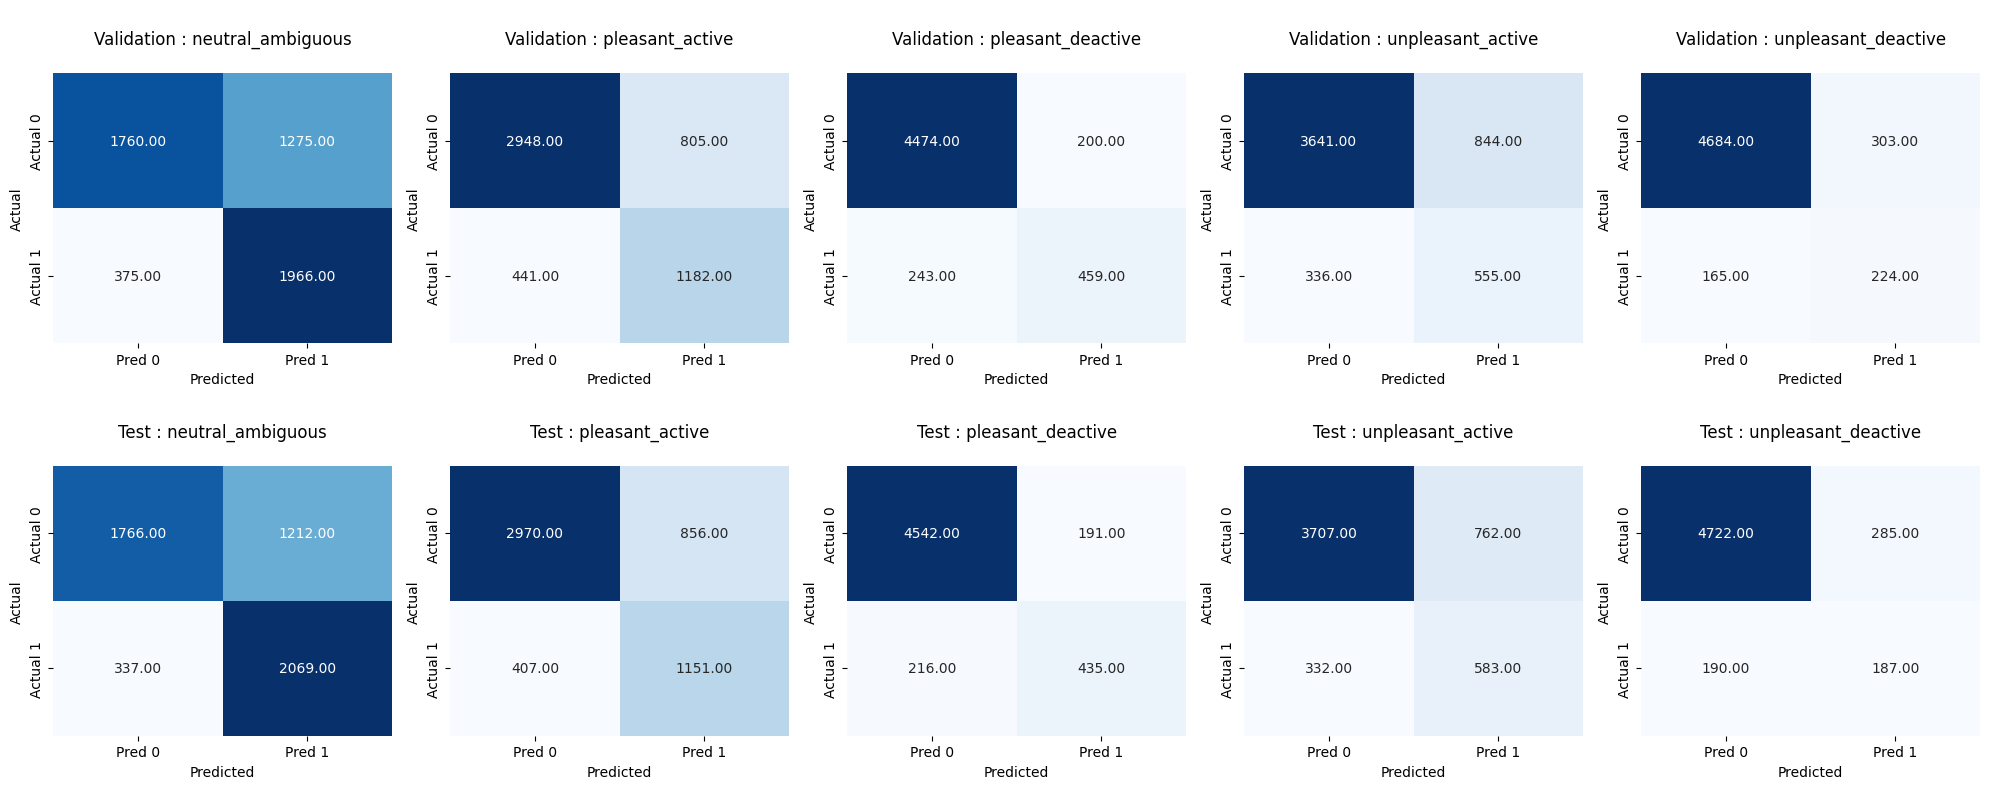

In [20]:
#compute per-category confusion matrices for val and test splits
cm_val_svc_quadrant=utils.confusion_matrices_per_label(
    y_val_cat, val_probs_cat_svc, ts_quadrant, categories)

cm_test_svc_quadrant=utils.confusion_matrices_per_label(
    y_test_cat, test_probs_cat_svc,ts_quadrant, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_svc_quadrant, cm_test_svc_quadrant, categories, normalize=False)

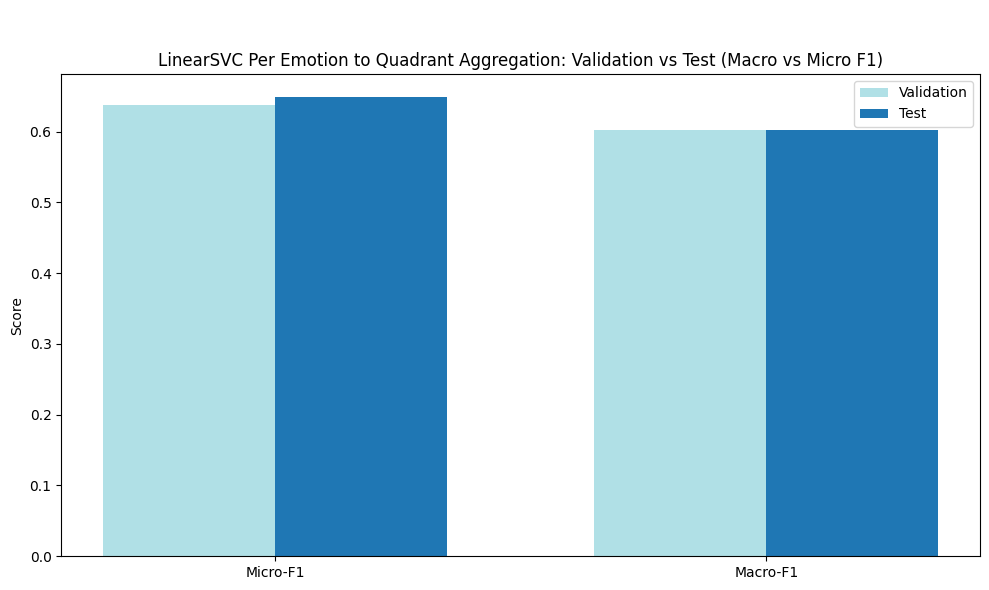

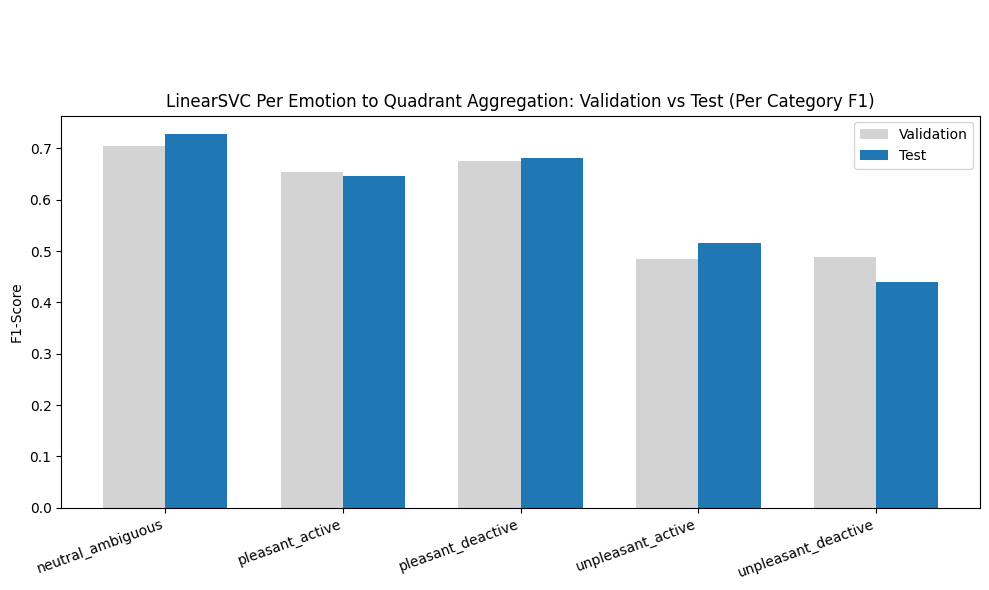

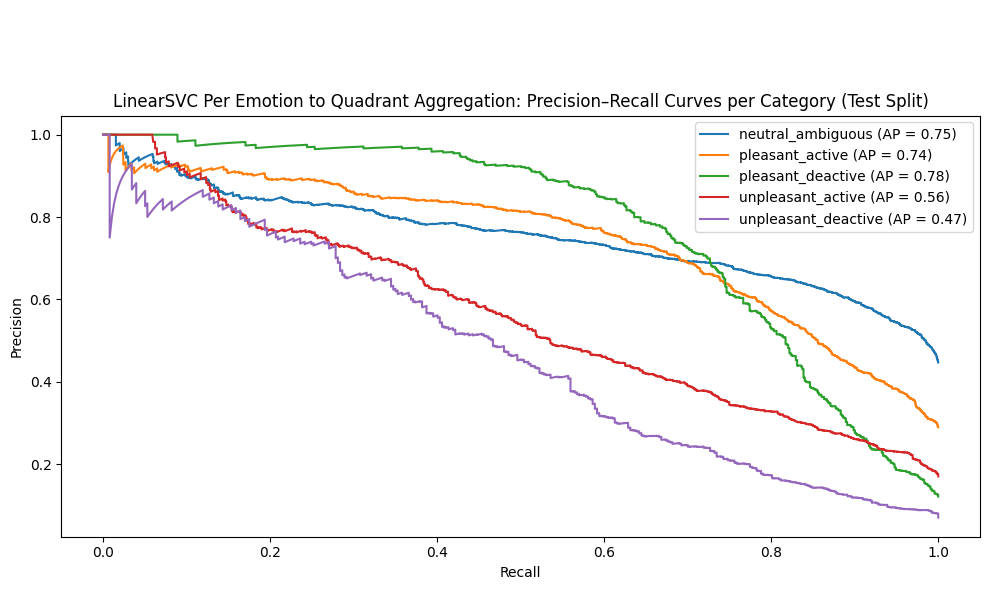

In [21]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_svc_per_emo, test_metrics_svc_per_emo, model_name="LinearSVC Per Emotion to Quadrant Aggregation")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_svc_per_emo, test_metrics_svc_per_emo, categories, model_name="\n\nLinearSVC Per Emotion to Quadrant Aggregation")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_svc_cat, categories, model_name="\n\nLinearSVC Per Emotion to Quadrant Aggregation")

#4.Updating Utility Module (utils.py) with Notebook 02 Functions

This section extends the shared utils.py module with additional functions required for affective quadrant aggregation and category-level evaluation.

In [22]:
#write shared utility functions to utils.py
%%writefile /content/drive/MyDrive/applied_research_project/utils.py

import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score, multilabel_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#define emotion groupings based on valence-arousal categories
pleasant_active = ['joy', 'love', 'admiration', 'amusement', 'excitement', 'pride', 'approval', 'desire']
pleasant_deactive = ['gratitude', 'relief', 'caring', 'optimism']
unpleasant_active = ['anger', 'annoyance', 'fear', 'disgust', 'nervousness', 'disapproval']
unpleasant_deactive = ['sadness', 'disappointment', 'remorse', 'embarrassment', 'grief']
neutral_ambiguous = ['neutral', 'surprise', 'curiosity', 'realization', 'confusion']

#map an emotion to its valence–arousal category
def categorize_emotion(emotion):
    if emotion in pleasant_active:
        return 'pleasant_active'
    elif emotion in pleasant_deactive:
        return 'pleasant_deactive'
    elif emotion in unpleasant_active:
        return 'unpleasant_active'
    elif emotion in unpleasant_deactive:
        return 'unpleasant_deactive'
    else:
        return 'neutral_ambiguous'


#aggregate emotion-level probabilities into category-level probabilities
def probs_emo_to_cat(probs_emo, categories, cat_to_emoIds, mode="noisy_or"):
  n, c=probs_emo.shape[0], len(categories)
  out=np.zeros((n,c), dtype=np.float32)
  for j, cat in enumerate(categories):
    idxs=cat_to_emoIds[cat]

    if len(idxs)==0:
      out[:,j]=0.0
    elif len(idxs)==1:
      out[:,j]=probs_emo[:,idxs[0]]
    elif mode=="noisy_or":
      out[:,j]=1.0-np.prod(1.0-probs_emo[:, idxs], axis=1)
    elif mode=="max":
      out[:,j]=probs_emo[:, idxs].max(axis=1)
    else:
      raise ValueError("Aggregation mode must be either 'noisy or' or 'max'")
  return out

#fixed 0.5 threshold baseline
def baseline_thresholds(y_val):
  num_labels = y_val.shape[1]
  return np.full(num_labels, 0.5)

#per label threshold optimisation using validation F1
def best_thresholds_per_label(val_scores, y_val, n_grid=50, use_quantiles=True, scores_are_logits=True):

  if scores_are_logits:
    val_scores= 1 / (1 + np.exp(-val_scores))

  num_labels = y_val.shape[1]
  best_ts = np.zeros(num_labels)


  for e in range(num_labels):
    scores_e = val_scores[:, e] #take all predicted values for label (e)
    y_true_e = y_val[:, e]      #take all actual values for label (e)

    if use_quantiles:
      q = np.linspace(0.02, 0.98, n_grid)
      candidcate_ts=np.quantile(scores_e, q) #get candidate thresholds from score quantiles
    else:
      candidcate_ts=np.linspace(scores_e.min(), scores_e.max(), n_grid)

    best_f1, best_t=-1.0, 0.5

    #evaluate each candidate threshold by its resulting F1 score
    for t in np.unique(candidcate_ts):
      y_pred_e = (scores_e >= t).astype(int)
      f1 = f1_score(y_true_e, y_pred_e, zero_division=0)

      if f1 > best_f1:
        best_f1, best_t = f1, t
    best_ts[e] = best_t
  return best_ts


#per category threshold tuning
def best_thresholds_per_category(val_scores, y_val, emo_to_cat, n_grid=50, use_quantiles=True, scores_are_logits=True):

  if scores_are_logits:
    val_scores= 1 / (1 + np.exp(-val_scores))

  num_labels = y_val.shape[1]
  categories = sorted(set(emo_to_cat))
  best_ts_cat = np.zeros(num_labels)

  for category in categories:
    emotion_id_cat=[i for i, c in enumerate(emo_to_cat) if c == category]
    scores_cat=val_scores[:, emotion_id_cat]
    y_true_cat=y_val[:, emotion_id_cat]

    flat_scores=scores_cat.reshape(-1)

    if use_quantiles:
      q=np.linspace(0.02, 0.98, n_grid)
      candidate_ts=np.quantile(flat_scores,q)
    else:
      candidate_ts=np.linspace(flat_scores.min(), flat_scores.max(), n_grid)

    best_f1, best_t=-1.0, 0.5

    for t in np.unique(candidate_ts):
      y_pred_cat=(scores_cat>=t).astype(int)

      f1s=[]
      for c in range (y_true_cat.shape[1]):
        if y_true_cat[:, c].sum()==0:
          continue
        f1s.append(f1_score(y_true_cat[:, c], y_pred_cat[:, c], zero_division=0))

        cat_macro_f1=np.mean(f1s) if len(f1s) else 0

        if cat_macro_f1>best_f1:
          best_f1, best_t=cat_macro_f1, t

    for c in emotion_id_cat:
      best_ts_cat[c]=best_t
  return best_ts_cat


#blend per-emotion and per-category thresholds using label frequency
def best_thresholds_blended(val_scores, y_val, emo_to_cat, k=50, n_grid=50, use_quantiles=True, scores_are_logits=True, clamp_quantiles=(0.05, 0.95)):

  if scores_are_logits:
    val_scores= 1 / (1 + np.exp(-val_scores))

  ts_per_emotion=best_thresholds_per_label(val_scores, y_val, n_grid, use_quantiles, scores_are_logits=True) #per-emotion thresholds

  ts_per_category=best_thresholds_per_category(val_scores, y_val, emo_to_cat, n_grid, use_quantiles) #per-category thresholds

  num_labels=y_val.shape[1]
  ts_blended=ts_per_emotion.copy()

  pos_counts=(y_val==1).sum(axis=0).astype(float)

  alpha=pos_counts/(pos_counts+k)
  ts_blended=alpha*ts_per_emotion+(1.0-alpha)*ts_per_category #blend weight (frequent labels use per-emotion threshold, rare labels use per-category threshold)

  #clamp each emotion threshold
  if clamp_quantiles is not None:
    q_low, q_high=clamp_quantiles
    for e in range(num_labels):
      low, high=np.quantile(val_scores[:,e], [q_low, q_high])
      ts_blended[e]=float(np.clip(ts_blended[e], low, high))

    return ts_blended

#evaluate predictions and report metrics
def evaluate_run(y_true, y_scores, thresholds, label_names=None, title="Evaluation Results", return_metrics=False):

    #apply thresholds to convert scores into binary predictions
    y_pred = (y_scores >= thresholds).astype(int)

    print(f"\n{title}")

    #compute evaluation metrics
    micro_f1=f1_score(y_true, y_pred, average='micro', zero_division=0)
    macro_f1=f1_score(y_true, y_pred, average='macro', zero_division=0)
    micro_precision=precision_score(y_true, y_pred, average='micro', zero_division=0)
    micro_recall=recall_score(y_true, y_pred, average='micro', zero_division=0)

    print(f"Micro F1: {micro_f1:.2f}")
    print(f"Macro F1: {macro_f1:.2f}")

    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_names, zero_division=0))

    if return_metrics==True:
      metrics={
          "micro-f1":micro_f1,
          "macro-f1":macro_f1,
          "micro-precision":micro_precision,
          "micro-recall":micro_recall,
          "per_label_f1":f1_score(y_true, y_pred, average=None, zero_division=0),
          "per_label_precision":precision_score(y_true, y_pred, average=None, zero_division=0),
          "per_label_recall":recall_score(y_true, y_pred, average=None, zero_division=0)
      }

      return metrics

#compute per-label confusion matrices
def confusion_matrices_per_label(y_true, y_scores, thresholds, label_names=None):
  y_pred = (y_scores >= thresholds).astype(int)

  #compute confusion matrices for each label
  mcm=multilabel_confusion_matrix(y_true, y_pred)

  num_labels=mcm.shape[0]
  if label_names is None:
    label_names=[f"Label {i}" for i in range(num_labels)]
  cm_dict={}
  for i, name in enumerate(label_names):
    TN, FP, FN, TP=mcm[i].ravel()
    cm_dict[name]={
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "matrix":mcm[i]
    }
  return cm_dict

#plot validation and test confusion matrices
def plot_cm(cm_val_dict, cm_test_dict, label_names, normalize=False):

  num_labels=len(label_names)

  fig, axes=plt.subplots(
      nrows=2, ncols=num_labels,
      figsize=(4*num_labels, 8)
  )

  if num_labels==1:
    axes=np.array([[axes[0]], [axes[1]]])

  for row_idx, (cm_dict, row_title) in enumerate([
      (cm_val_dict, "Validation"),
      (cm_test_dict, "Test")
  ]):
    for col_idx, label in enumerate(label_names):

      ax=axes[row_idx, col_idx]
      cm=np.asarray(cm_dict[label]["matrix"])
      if normalize:
        total=cm.sum()
        cm_plot=cm/total if total>0 else cm.astype(float)
      else:
        cm_plot=cm

      sns.heatmap(cm_plot, annot=True, fmt=".2f", cmap="Blues", cbar=False, xticklabels=["Pred 0", "Pred 1"], yticklabels=["Actual 0", "Actual 1"], ax=ax)

      ax.set_title(f"\n\n{row_title} : {label}\n")
      ax.set_ylabel("Actual")
      ax.set_xlabel("Predicted")

  plt.tight_layout()
  plt.show()

#plot validation vs test micro and macro F1
def plot_val_test_macro_micro(val_metrics, test_metrics, model_name="Model"):
  labels=["Micro-F1", "Macro-F1"]
  val_scores=[val_metrics["micro-f1"], val_metrics["macro-f1"]]
  test_scores=[test_metrics["micro-f1"], test_metrics["macro-f1"]]

  x=np.arange(len(labels))
  width=0.35

  plt.figure(figsize=(10,6))
  plt.bar(x-width/2, val_scores, width, label="Validation", color="powderblue")
  plt.bar(x+width/2, test_scores, width, label="Test")

  plt.xticks(x, labels)
  plt.ylim(0,1.0)
  plt.ylabel("Score")
  plt.title(f"{model_name}: Validation vs Test (Macro vs Micro F1)")
  plt.legend()
  plt.tight_layout()
  plt.show()

#plot per-category F1 comparison between val and test splits
def plot_val_test_per_cat_f1(val_metrics, test_metrics, categories, model_name="Model"):
  categories=list(categories)

  val_f1_per_cat  = val_metrics["per_label_f1"]
  test_f1_per_cat = test_metrics["per_label_f1"]

  x = np.arange(len(categories))
  width = 0.35

  plt.figure(figsize=(10,6))
  plt.bar(x-width/2, val_f1_per_cat, width, label="Validation", color="lightgray")
  plt.bar(x+width/2, test_f1_per_cat, width, label="Test")

  plt.xticks(x, categories, rotation=20, ha='right')
  plt.ylim(0,1.0)
  plt.ylabel("F1-Score")
  plt.title(f"{model_name}: Validation vs Test (Per Category F1)")
  plt.legend()
  plt.tight_layout()
  plt.show()

#plot precision-recall curves per category
def plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name="Model"):
  categories=list(categories)
  plt.figure(figsize=(10,6))

  for j, cat in enumerate(categories):
    y_true_cat  = y_test_cat[:, j]
    y_score_cat = test_scores_cat[:, j]

    precision, recall, _ = precision_recall_curve(y_true_cat, y_score_cat)
    avg_precision = average_precision_score(y_true_cat, y_score_cat)

    plt.plot(recall, precision, label=f"{cat} (AP = {avg_precision:.2f})")

  plt.xlabel("Recall")
  plt.ylabel("Precision")
  plt.title(f"{model_name}: Precision–Recall Curves per Category (Test Split)")
  plt.tight_layout()
  plt.legend()
  plt.show()

#convert emotion-level labels to category-level labels
def y_to_categories(y, categories, cat_to_emoIds):
  y_cat=np.zeros((y.shape[0], len(categories)), dtype=int)
  for j, c in enumerate(categories):
    y_cat[:, j]=(y[:, cat_to_emoIds[c]].sum(axis=1)>0).astype(int)
  return y_cat


Overwriting /content/drive/MyDrive/applied_research_project/utils.py
